<center>

# __Introduction to SHAP (Appendix for Explaining Text and Images)__

<br>

Dr. [Jose Maria Alonso-Moral](https://citius.gal/team/jose-maria-alonso-moral/)

_Centro Singular de Investigación en Tecnoloxías Intelixentes (CiTIUS)_

_Universidade de Santiago de Compostela_

_ETSE-USC, Campus Vida, Santiago de Compostela, Spain_

<br>

Mr. [Pablo Miguel Perez-Ferreiro](https://citius.gal/team/pablo-miguel-perez-ferreiro/)

_Centro Singular de Investigación en Tecnoloxías Intelixentes (CiTIUS)_

_Universidade de Santiago de Compostela_

_ETSE-USC, Campus Vida, Santiago de Compostela, Spain_

<br>

__27 January 2026__
 
__Explainable and Trustworthy AI__

<br>

![MIA.png](MIA.png)

</center>

# 1. **Introduction**

This interactive appendix includes supplementary material for the first TXAI in the Lab hands-on session (**I1. "Introduction to SHAP"**) in the Subject **Explainable and Trustworthy AI** (Master in Artificial Intelligence); on how to apply SHAP values to endow interpretability to text-based and image-based problems. The session is leaded by [Jose M. Alonso-Moral](https://citius.gal/team/jose-maria-alonso-moral) and [Pablo Miguel Perez-Ferreiro](https://citius.gal/team/pablo-miguel-perez-ferreiro/) at USC, [Samuel Suárez Marcote](https://pdi.udc.es/es/File/Pdi/UA4VL![imagen.png](attachment:imagen.png)) at UDC, and [David Nicholas Olivieri Cecchi](https://www.uvigo.gal/es/universidad/administracion-personal/pdi/david-nicholas-olivieri-cecchi) at UVigo.

# **2. Settings**
Installation of the required libraries

In [1]:
## this code is developed by Jose Maria Alonso-Moral
import os

# Generic libraries
os.system("pip install numba==0.59.1 --quiet")
os.system("pip install numpy==1.26.4 --quiet")
os.system("pip install shap==0.46.0 --quiet")

# libraries for image processing
os.system("pip install opencv-python==4.9.0.80 --quiet")
os.system("pip install tensorflow --quiet")

# libraries for text processing
os.system("pip install transformers --quiet")
os.system("pip install tf-keras --quiet")
os.system("pip install wordcloud==1.9.3 --quiet")

0

In [2]:
## this code is developed by Jose Maria Alonso-Moral
import warnings
warnings.filterwarnings('ignore')

# Loading csv package for reading data files
import pandas as pd

# Loading lib to support handling of confusion matrix
import numpy as np

# Loading plot tools 
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import math

# Loading a library to handle SHAP Values
import shap

import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import DataCollatorWithPadding, TrainingArguments, Trainer

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import cv2

import tensorflow as tf
print(tf.__version__)

import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F

2026-01-26 17:46:36.412553: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-26 17:46:38.963356: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


2.20.0


## **3. Visualizing explanations provided by SHAP for texts and images**

### **3.1. Explaining text classification: Amazon Review Sentimental Analysis**

In this section, we will use the [Amazon Reviews dataset](https://snap.stanford.edu/data/web-Amazon.html). It contains 35M reviews which were filled in by about 7M users regarding about 2.5M products. We will use a subset of the original dataset which contains 80k examples (72k examples for training and 8k examples for test).

Let's start by loading the data and taking a look at data distribution.

In [3]:
## this code is developed by Jose Maria Alonso-Moral
AR_train = pd.read_csv("testlib/AREV/amazon_review_train.csv", sep=',')
AR_test = pd.read_csv("testlib/AREV/amazon_review_test.csv", sep=',')

In [4]:
## this code is developed by Jose Maria Alonso-Moral
AR_train.head(n=10)

,label,title,review
0,1,Excellent home help for parents,Volume 1 of Dolch Sight Work Activities for gr...
1,0,"Stay far, far away.","I made it through about 6, maybe 7 minutes of ..."
2,0,Lost Woods,Lost WoodsI didn't really understand the movie...
3,0,"Renaissance -12, Women's brown suead shoes",Recomend ordering atleast 1/2 size to a full s...
4,1,Best Novel I've Read This Year,Intrigued by the variety of comments on Richar...
5,0,No replacements,We bought this one for my first child. Loved i...
6,1,Milo is the best!,This band is so awesome. A combination of jazz...
7,1,"If not the best ,one of the best female vocali...","Excellent Music ,now you know why Mick Jagger ..."
8,1,lots of fun,I had fun with this house. I have most of the ...
9,0,Too easy to open!,Definitely put this out of your child's reach....


In [5]:
## this code is developed by Jose Maria Alonso-Moral
AR_test.head(n=10)

,label,title,review
0,1,Best Movie I've Seen in Years!,"Okay, it was expensive to see Pirates of the C..."
1,0,Jai Uttal's voice ruins it for me.,I really enjoy Indian Fusion music. I know Jai...
2,0,Disappointing,As a great fan of Elizabeth George and her Bri...
3,1,Highway to Heaven for Vespa-holics!!,"As a confirmed ""Vespa-holic"" [I currently own ..."
4,0,Caveat emptor,They don't tell you that the game will not pla...
5,0,WHAT A BEAUTIFUL IPOD ITEM !,Just take a look at the cover... a sellout ban...
6,1,Kutless,"A great first album, with memorable rock songs..."
7,1,To the children of the emlightened.,I liked this book because it helps one to see ...
8,0,These recipes are NOT low-sodium!,I can't believe the American Heart Association...
9,0,"Only Similarities, No Differences",The greatest problem with this book is Mr. Cam...


<Axes: xlabel='label', ylabel='count'>

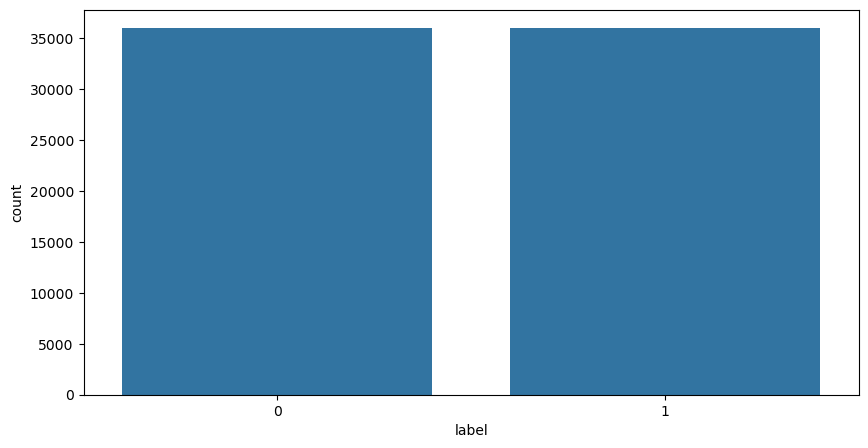

In [6]:
## this code is developed by Jose Maria Alonso-Moral
# 0 -> negative review
# 1 -> positive review
plt.figure(figsize=(10,5))
sns.countplot(x='label', data=AR_train)

<Axes: xlabel='label', ylabel='count'>

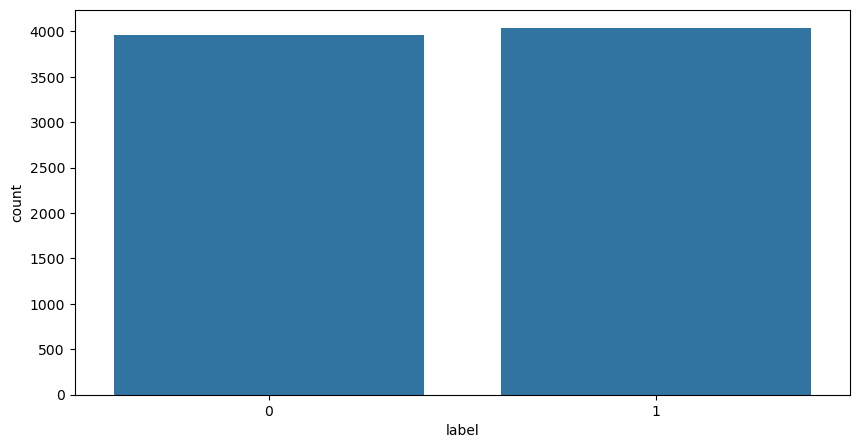

In [7]:
## this code is developed by Jose Maria Alonso-Moral
# 0 -> negative review
# 1 -> positive review
plt.figure(figsize=(10,5))
sns.countplot(x='label', data=AR_test)

There are 1760917 words in the combination of all reviews.


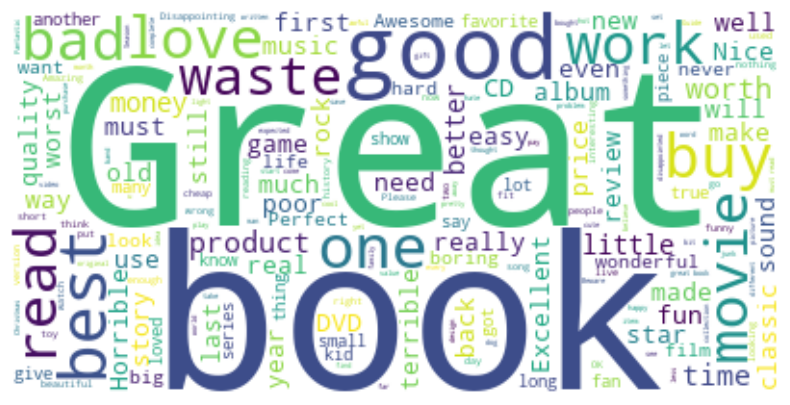

In [8]:
## this code is developed by Jose Maria Alonso-Moral
# Titles (training):
titleTrain = AR_train.title[:len(AR_train.title)]
textTitleTrain = ""
for ele in titleTrain:
        textTitleTrain += str(ele)

# Create and generate a word cloud image:
print ("There are {} words in the combination of all reviews.".format(len(textTitleTrain)))
stopwords = set(STOPWORDS)
wordcloud1 = WordCloud(stopwords=stopwords, background_color="white").generate(textTitleTrain)

# Display the generated image:
plt.figure(figsize=(10,5))
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

There are 195332 words in the combination of all reviews.


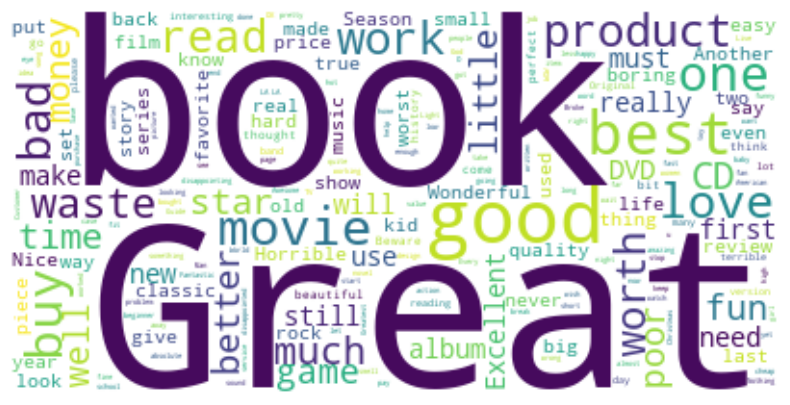

In [9]:
## this code is developed by Jose Maria Alonso-Moral
# Titles (test):
titleTest = AR_train.title[:len(AR_test.title)]
textTitleTest = ""
for ele in titleTest:
        textTitleTest += str(ele)

# Create and generate a word cloud image:
print ("There are {} words in the combination of all reviews.".format(len(textTitleTest)))
stopwords = set(STOPWORDS)
wordcloud2 = WordCloud(stopwords=stopwords, background_color="white").generate(textTitleTest)

# Display the generated image:
plt.figure(figsize=(10,5))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

There are 29149910 words in the combination of all reviews.


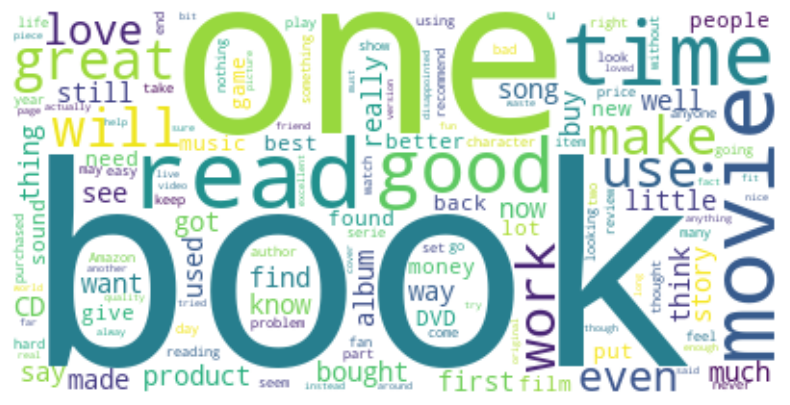

In [10]:
## this code is developed by Jose Maria Alonso-Moral
# Reviews (training):
reviewTrain = AR_train.review[:len(AR_train.review)]
textReviewTrain = ""
for ele in reviewTrain:
        textReviewTrain += str(ele)

# Create and generate a word cloud image:
print ("There are {} words in the combination of all reviews.".format(len(textReviewTrain)))
stopwords = set(STOPWORDS)
wordcloud3 = WordCloud(stopwords=stopwords, background_color="white").generate(textReviewTrain)

# Display the generated image:
plt.figure(figsize=(10,5))
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis("off")
plt.show()

There are 3254674 words in the combination of all reviews.


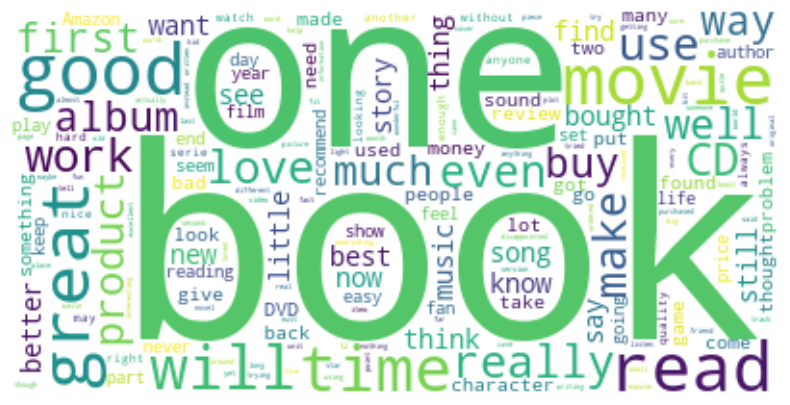

In [11]:
## this code is developed by Jose Maria Alonso-Moral
# Reviews (test):
reviewTest = AR_test.review[:len(AR_test.review)]
textReviewTest = ""
for ele in reviewTest:
        textReviewTest += str(ele)

# Create and generate a word cloud image:
print ("There are {} words in the combination of all reviews.".format(len(textReviewTest)))
stopwords = set(STOPWORDS)
wordcloud4 = WordCloud(stopwords=stopwords, background_color="white").generate(textReviewTest)

# Display the generated image:
plt.figure(figsize=(10,5))
plt.imshow(wordcloud4, interpolation='bilinear')
plt.axis("off")
plt.show()

In [12]:
## this code is developed by Jose Maria Alonso-Moral
ARx_train = AR_train.drop(['label', 'title'], axis=1)
ARy_train = AR_train['label']
ARx_test = AR_test.drop(['label', 'title'], axis=1)
ARy_test = AR_test['label']

In [13]:
## this code is developed by Jose Maria Alonso-Moral
modelT_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = transformers.AutoTokenizer.from_pretrained(modelT_name)
modelT = transformers.pipeline("text-classification", model=modelT_name)

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: cardiffnlp/twitter-roberta-base-sentiment
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [14]:
## this code is developed by Jose Maria Alonso-Moral
tweets = ["I hate people", "I love people", "People are normal"]
predictions = modelT(tweets, truncation=True)

categories = {'LABEL_0':'Negative','LABEL_1':'Neutral','LABEL_2':'Positive'}

for index,prediction in enumerate(predictions):
    print(f"Tweet: {tweets[index]} | Sentiment: {categories[prediction['label']]}")

Tweet: I hate people | Sentiment: Negative
Tweet: I love people | Sentiment: Positive
Tweet: People are normal | Sentiment: Neutral


In [15]:
## this code is developed by Jose Maria Alonso-Moral
explainerT = shap.Explainer(modelT, modelT.tokenizer)

In [16]:
## this code is developed by Jose Maria Alonso-Moral
def getTextPlot(model,explainer,sample):
    prediction = model([sample], truncation=True)[0]
    categories = {'LABEL_0':'Negative','LABEL_1':'Neutral','LABEL_2':'Positive'}
    print(f"Review: {sample}\nSentiment: {categories[prediction['label']]}")
    shap_values = explainer([sample])
    text_target = str(prediction['label'])
    shap.plots.text(shap_values[:,:,text_target])
    print(" ")

Now, we will go in depth with some examples in the test dataset (the first k examples).

In [17]:
## this code is developed by Jose Maria Alonso-Moral
k = 2
print(ARx_test[:k])
print(ARy_test[:k])
rev = AR_test.review[:k]
textRev = ""
for ele in rev:
        textRev += str(ele)

for rr in rev:
    getTextPlot(modelT,explainerT,rr)

                                              review
0  Okay, it was expensive to see Pirates of the C...
1  I really enjoy Indian Fusion music. I know Jai...
0    1
1    0
Name: label, dtype: int64
Review: Okay, it was expensive to see Pirates of the Caribbean THREE TIMES, but it was worth it. Not too scary, if you have little ones to think of, but thrilling for even the most experienced of viewers. Trust me. No matter how old, or young, you are, you will LOVE this movie!
Sentiment: Positive


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:58, 58.63s/it]                                                                    


 
Review: I really enjoy Indian Fusion music. I know Jai Uttal is quite popular and I listened to sample tracks on this CD and was impressed with some of the instrumentals. However on receiving the CD and listening to the full tracks, I was very disappointed. Jai Uttal's voice ruins it for me. I simply don't like the sound of his voice and there's too much of it. He sounds like a white guy doing a very poor and muffled job on bhajans. His voice is flat, monotonous, and off pitch. And he butchers the correct pronunciation of the sanskrit bhajans. Some of the instrumentals are pretty good, then disappointedly his voice kicks in and dominates most of each track. After so much of it, you have to switch it to the next track only for a repeat of the same thing. His album graphics and titles are pretty cool, but don't be mislead.
Sentiment: Negative


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:56, 116.28s/it]                                                                   


__Let us use now other complementary SHAP plots for visualizing the previous explanations.__

In [18]:
## this code is developed by Jose Maria Alonso-Moral
print(rev)

dt_examples = []
exp = rev[:k]
for ele in exp:
        dt_examples.append(ele)

shap_values = explainerT(dt_examples)

0    Okay, it was expensive to see Pirates of the C...
1    I really enjoy Indian Fusion music. I know Jai...
Name: review, dtype: object


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|███████████████████████████████▌                               | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [02:45, 82.61s/it]                                                                    


You can visualize the **Shapley values associated to a sequence of words.**

['Okay' ', ' 'it ' 'was ' 'expensive ' 'to ' 'see ' 'Pirates ' 'of '
 'the ' 'Caribbean ' 'THREE ' 'TIM' 'ES' ', ' 'but ' 'it ' 'was ' 'worth '
 'it' '. ' 'Not ' 'too ' 'scary' ', ' 'if ' 'you ' 'have ' 'little '
 'ones ' 'to ' 'think ' 'of' ', ' 'but ' 'thrilling ' 'for ' 'even '
 'the ' 'most ' 'experienced ' 'of ' 'viewers' '. ' 'Trust ' 'me' '. '
 'No ' 'matter ' 'how ' 'old' ', ' 'or ' 'young' ', ' 'you ' 'are' ', '
 'you ' 'will ' 'LOVE ' 'this ' 'movie' '!' '']


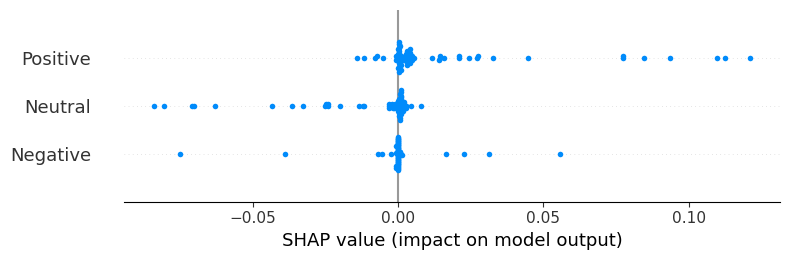

In [19]:
sv= shap_values[0] # you can change 0 / 1 to select the first or the second sentence
ini=1
#end=10
end=len(sv.data)
print(sv.data[ini:end])
shap.summary_plot(sv.values[ini:end], feature_names=['Negative', 'Neutral', 'Positive'])

But you can also visualize the **Shapley values for a single word.**

['LOVE ']


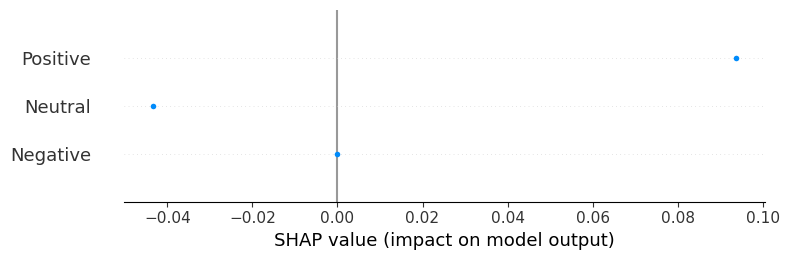

In [20]:
sv= shap_values[0] # you can change 0 / 1 to select the first or the second sentence
ini=sv.data.tolist().index('LOVE ')
end=ini+1
print(sv.data[ini:end])
shap.summary_plot(sv.values[ini:end], feature_names=['Negative', 'Neutral', 'Positive'])

['I ' 'really ' 'enjoy ' 'Indian ' 'Fusion ' 'music' '. ' 'I ' 'know ' 'J'
 'ai ' 'Utt' 'al ' 'is ' 'quite ' 'popular ' 'and ' 'I ' 'listened ' 'to '
 'sample ' 'tracks ' 'on ' 'this ' 'CD ' 'and ' 'was ' 'impressed '
 'with ' 'some ' 'of ' 'the ' 'instrument' 'als' '. ' 'However ' 'on '
 'receiving ' 'the ' 'CD ' 'and ' 'listening ' 'to ' 'the ' 'full '
 'tracks' ', ' 'I ' 'was ' 'very ' 'disappointed' '. ' 'J' 'ai ' 'Utt'
 'al' "'s " 'voice ' 'ruins ' 'it ' 'for ' 'me' '. ' 'I ' 'simply ' 'don'
 "'t " 'like ' 'the ' 'sound ' 'of ' 'his ' 'voice ' 'and ' 'there' "'s "
 'too ' 'much ' 'of ' 'it' '. ' 'He ' 'sounds ' 'like ' 'a ' 'white '
 'guy ' 'doing ' 'a ' 'very ' 'poor ' 'and ' 'muff' 'led ' 'job ' 'on '
 'b' 'h' 'aj' 'ans' '. ' 'His ' 'voice ' 'is ' 'flat' ', ' 'mon' 'oton'
 'ous' ', ' 'and ' 'off ' 'pitch' '. ' 'And ' 'he ' 'but' 'chers ' 'the '
 'correct ' 'pronunciation ' 'of ' 'the ' 's' 'ansk' 'rit ' 'b' 'h' 'aj'
 'ans' '. ' 'Some ' 'of ' 'the ' 'instrument' 'als ' 'are ' 'pr

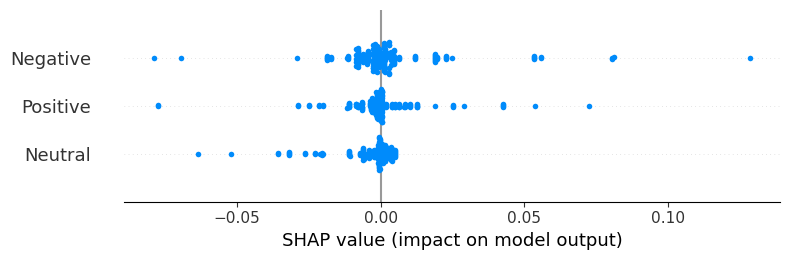

In [21]:
sv= shap_values[1] # you can change 0 / 1 to select the first or the second sentence
ini=1
#end=10
end=len(sv.data)
print(sv.data[ini:end])
shap.summary_plot(sv.values[ini:end], feature_names=['Negative', 'Neutral', 'Positive'])

['poor ']


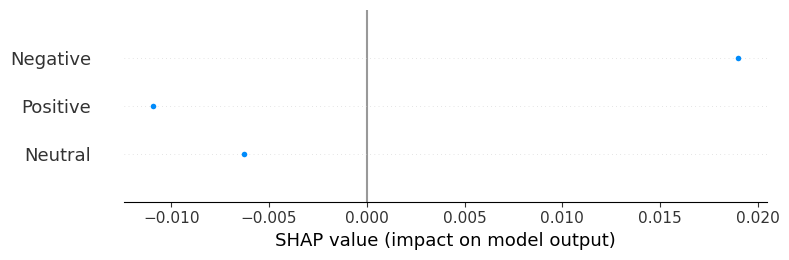

In [22]:
sv= shap_values[1] # you can change 0 / 1 to select the first or the second sentence
ini=sv.data.tolist().index('poor ')
end=ini+1
print(sv.data[ini:end])
shap.summary_plot(sv.values[ini:end], feature_names=['Negative', 'Neutral', 'Positive'])

### **3.2. Explaining Image Classification**

In this section we will see how to use SHAP for explaining image classification with Keras. We start with building a neural classifier. To do so, we reuse code from a [tensorflow-tutorial](https://www.tensorflow.org/tutorials/keras/classification).

In [23]:
## this code is developed by Jose Maria Alonso-Moral
fashion_train = pd.read_csv("testlib/FMNIST/fashion-mnist_train.csv", sep=',')
fashion_test = pd.read_csv("testlib/FMNIST/fashion-mnist_test.csv", sep=',')
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

<Axes: xlabel='label', ylabel='count'>

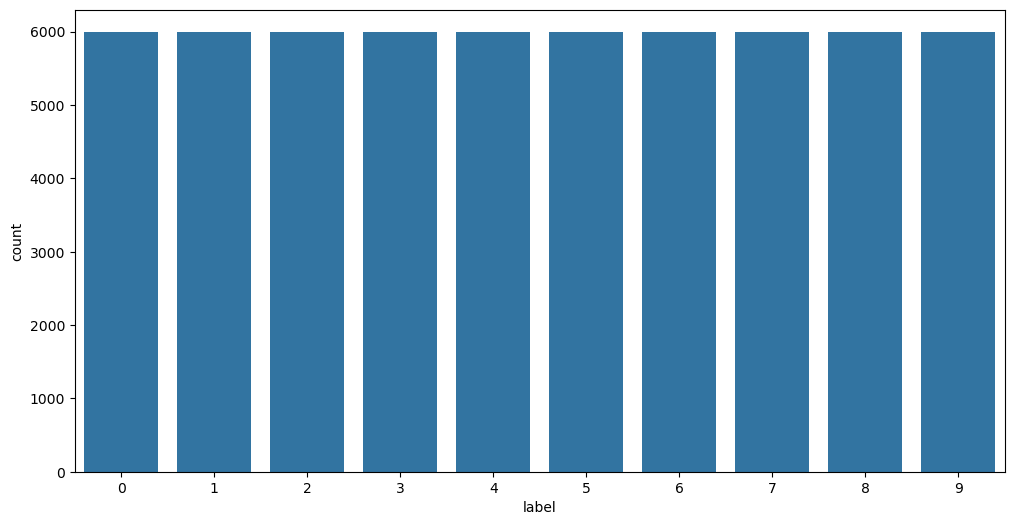

In [24]:
## this code is developed by Jose Maria Alonso-Moral
plt.figure(figsize=(12,6))
sns.countplot(x='label', data=fashion_train)

<Axes: xlabel='label', ylabel='count'>

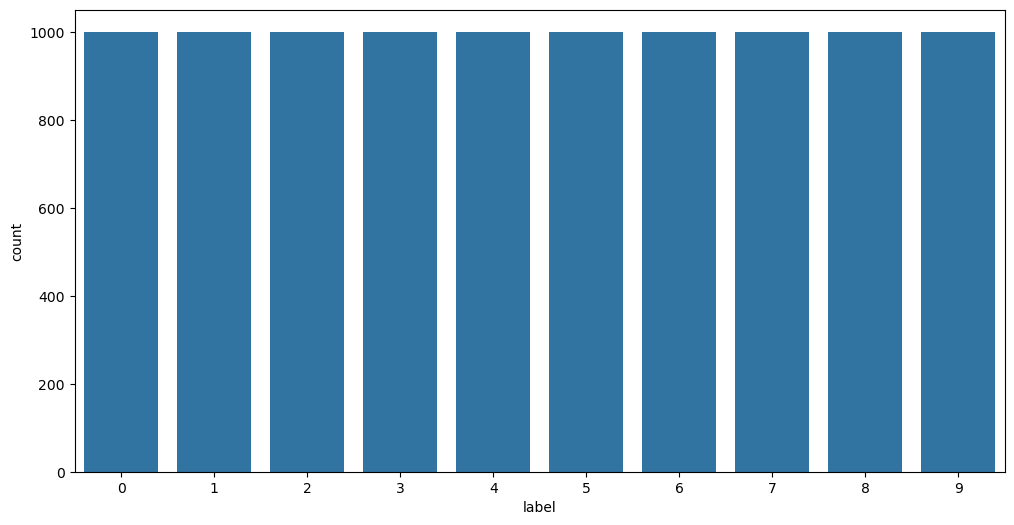

In [25]:
## this code is developed by Jose Maria Alonso-Moral
plt.figure(figsize=(12,6))
sns.countplot(x='label', data=fashion_test)

In [26]:
## this code is developed by Jose Maria Alonso-Moral
fashion_train.head(n=10)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4,0,0,0,5,4,5,5,3,5,...,7,8,7,4,3,7,5,0,0,0
6,4,0,0,0,0,0,0,0,0,0,...,14,0,0,0,0,0,0,0,0,0
7,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,4,0,0,0,0,0,0,3,2,0,...,1,0,0,0,0,0,0,0,0,0
9,8,0,0,0,0,0,0,0,0,0,...,203,214,166,0,0,0,0,0,0,0


In [27]:
## this code is developed by Jose Maria Alonso-Moral
fashion_test.head(n=10)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2,0,0,0,0,0,44,105,44,10,...,105,64,30,0,0,0,0,0,0,0
6,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,6,0,0,0,0,0,0,0,1,0,...,174,136,155,31,0,1,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,57,70,28,0,2,0,0,0,0,0


Normalizing and reshaping data.

In [28]:
## this code is developed by Jose Maria Alonso-Moral
features_test, target_test=fashion_test.iloc[:, 1:], fashion_test.iloc[:, 0:1]
features_train, target_train=fashion_train.iloc[:, 1:], fashion_train.iloc[:, 0:1]
train_images, train_labels= features_train.to_numpy(), target_train.to_numpy()
test_images, test_labels= features_test.to_numpy(), target_test.to_numpy()

In [29]:
## this code is developed by Jose Maria Alonso-Moral
train_images = train_images.astype("float64")/255.0
test_images = test_images.astype("float64")/255.0

In [30]:
## this code is developed by Jose Maria Alonso-Moral
train_images = np.reshape(train_images, (60000, 28, 28, 1))
test_images = np.reshape(test_images, (10000, 28, 28, 1))
print("train_images shape:", train_images.shape)
print("test_images shape:", test_images.shape)
print(train_images.shape[0], "train samples")
print(test_images.shape[0], "test samples")

train_images shape: (60000, 28, 28, 1)
test_images shape: (10000, 28, 28, 1)
60000 train samples
10000 test samples


In [31]:
## this code is developed by Jose Maria Alonso-Moral
cv2_train=features_train.values
cv2_test=features_test.values
type(features_train.values)

numpy.ndarray

Visualizing training examples.

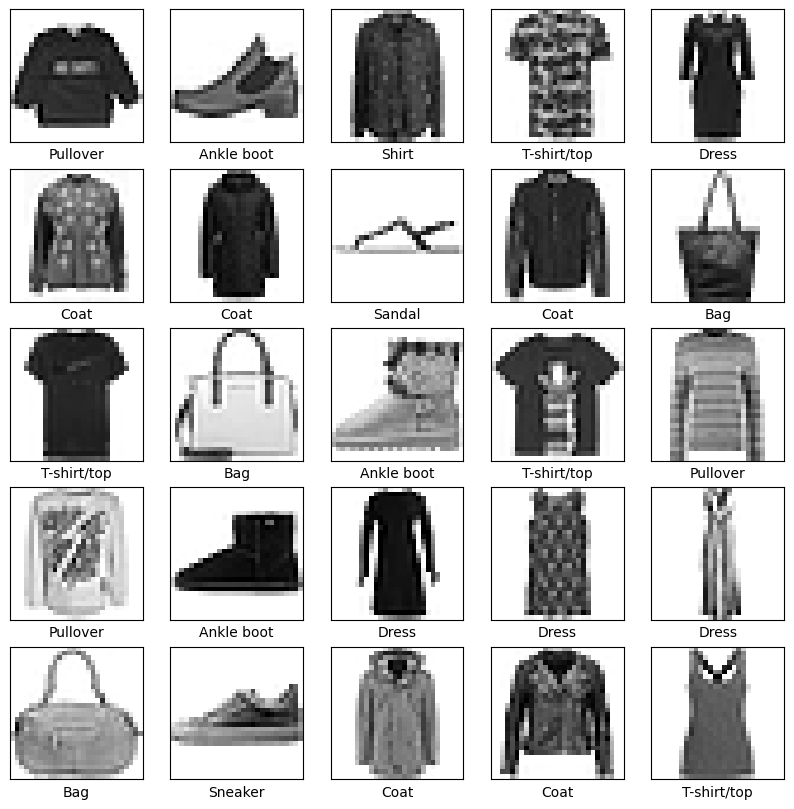

In [32]:
## this code is developed by Jose Maria Alonso-Moral
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

Visualizing test examples.

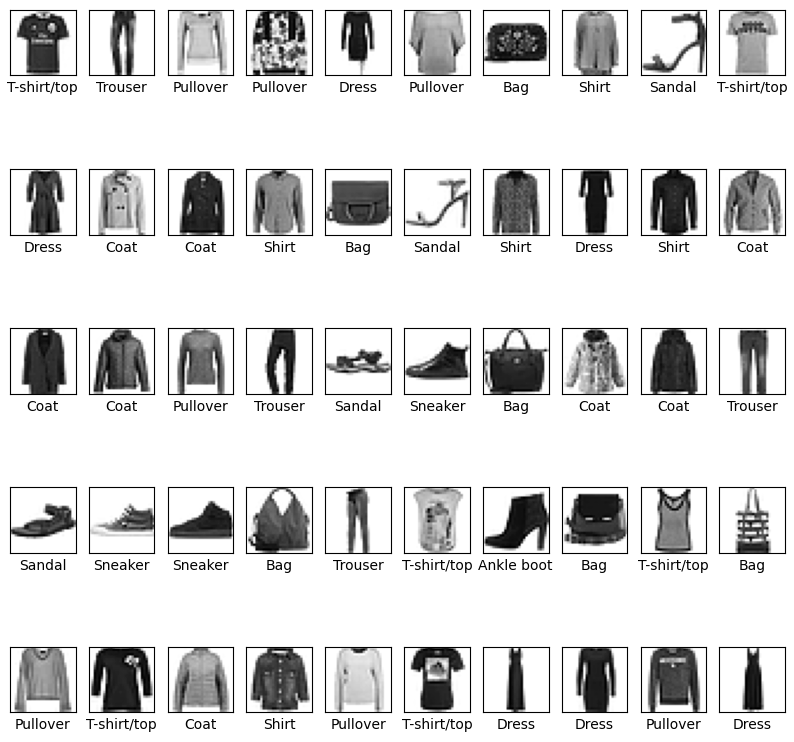

In [33]:
## this code is developed by Jose Maria Alonso-Moral
plt.figure(figsize=(10,10))
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[test_labels[i][0]])
plt.show()

Building the Neural Network (NN) with Keras

In [34]:
## this code is developed by Jose Maria Alonso-Moral
# Basic model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

model.summary()

2026-01-26 18:25:36.378211: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,842 (143.91 KB)

 Trainable params: 36,842 (143.91 KB)

 Non-trainable params: 0 (0.00 B)

Compile the NN

In [35]:
## this code is developed by Jose Maria Alonso-Moral
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Train the NN

In [36]:
## this code is developed by Jose Maria Alonso-Moral
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10


2026-01-26 18:25:39.885803: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8110 - loss: 0.5210
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8600 - loss: 0.3847
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8703 - loss: 0.3529
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8788 - loss: 0.3310
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8838 - loss: 0.3157
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8882 - loss: 0.3018
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8920 - loss: 0.2933
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8956 - loss: 0.2807
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8975 - loss: 0.2745
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9005 - loss: 0.2665


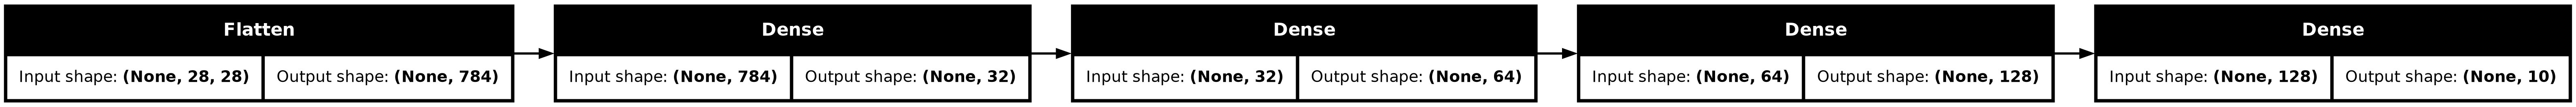

In [37]:
## this code is developed by Jose Maria Alonso-Moral
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

Evaluate the NN

In [38]:
## this code is developed by Jose Maria Alonso-Moral
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 0s - 1ms/step - accuracy: 0.8820 - loss: 0.3237

Test accuracy: 0.8820000290870667


Make predictions

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step


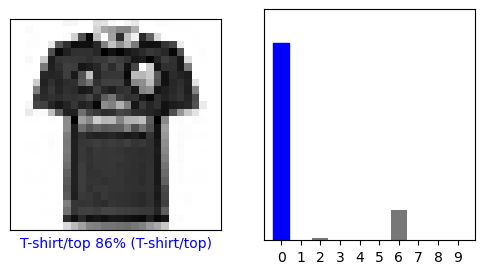

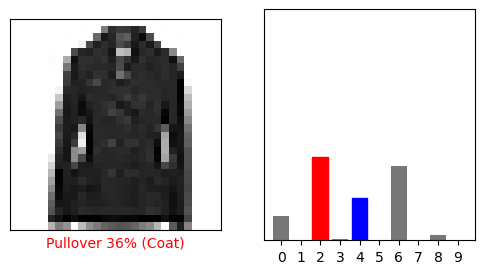

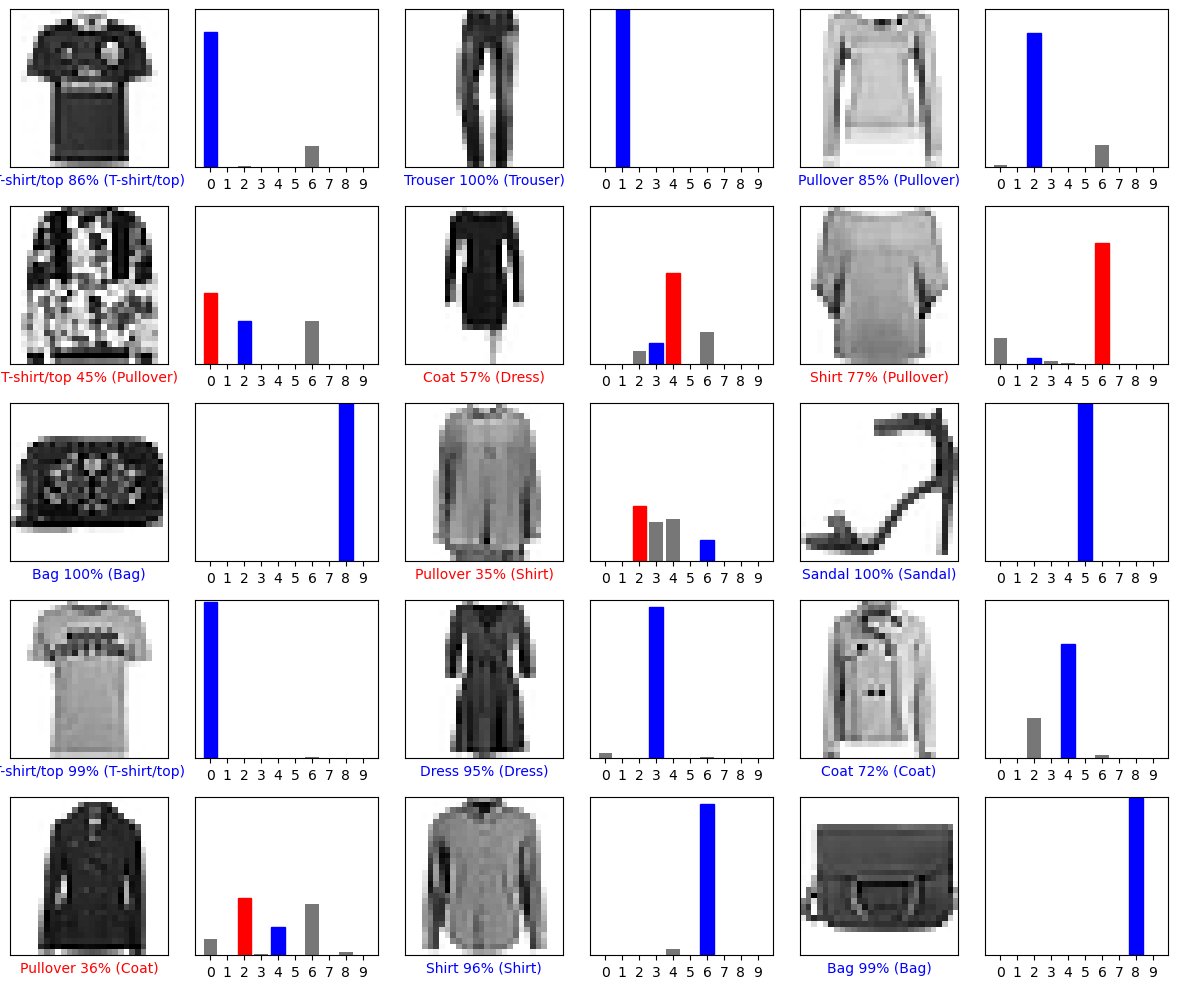

In [39]:
## this code is developed by Jose Maria Alonso-Moral
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

predictions = probability_model.predict(test_images)
#print(predictions[0])
np.argmax(predictions[0])
#print(test_labels[0][0])

def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label[0]]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label[0]].set_color('blue')

# for plotting a single case (i is the index of the example)
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

**SHAP explanations for image predictions**

In [40]:
## this code is developed by Jose Maria Alonso-Moral
shap.initjs()

Building the explainer

In [41]:
## this code is developed by Jose Maria Alonso-Moral
# SHAP for full fashion_mnist
masker = shap.maskers.Image("inpaint_telea", train_images[0].shape)
print(train_images[0].shape)
explainerKeras = shap.Explainer(model, masker, output_names=class_names)
print(explainerKeras)

(28, 28, 1)
shap.explainers.PartitionExplainer()


Visualizing **aggregated explanations.**

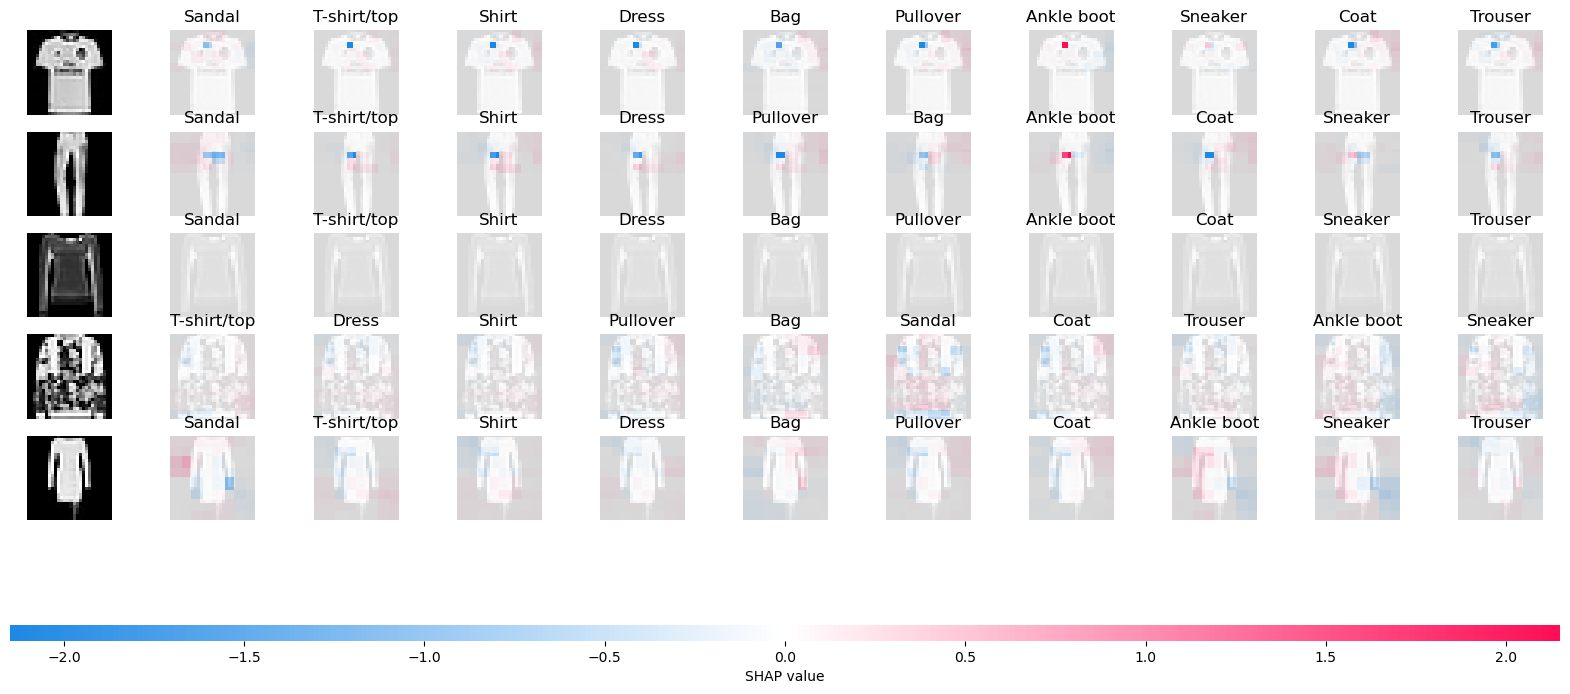

In [42]:
## this code is developed by Jose Maria Alonso-Moral
mapping = {0:"T-shirt/top",1:"Trouser",2:"Pullover",3:"Dress",4:"Coat",5:"Sandal",6:"Shirt",7:"Sneaker",8:"Bag",9:"Ankle boot"}
shap_values = explainerKeras(test_images[:5], outputs=shap.Explanation.argsort.flip[:10])
shap.image_plot(shap_values)

Single prediction and explanation.

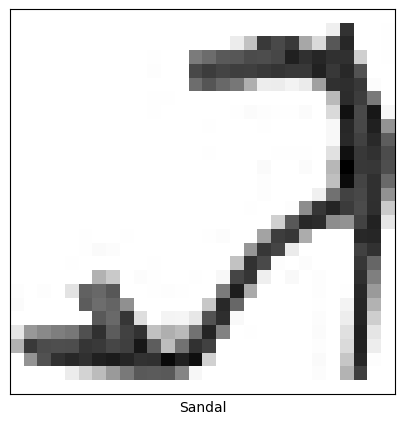

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[4.9814936e-08 1.7228672e-25 2.4411955e-20 9.0974193e-11 4.4580087e-21
  1.0000000e+00 1.6739775e-13 3.2639417e-19 7.7307504e-19 2.8631513e-13]]



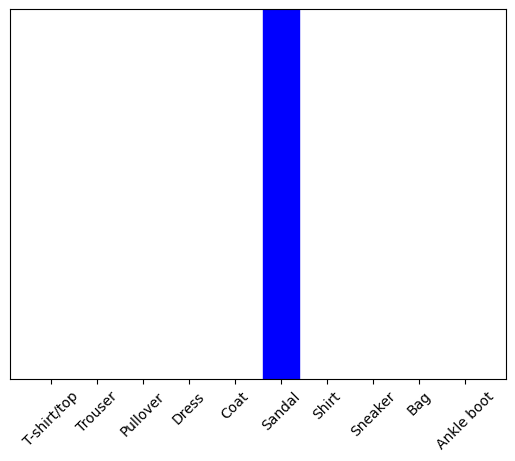

In [43]:
## this code is developed by Jose Maria Alonso-Moral
# Grab an image from the test dataset.
# examples:
# i = 0 (T-shirt/top)
# i = 1 (Trouser)
# i = 2 (Pullover)
# i = 4 (Dress)
# i = 11 (Coat)
# i = 8 (Sandal)
# i = 7 (Shirt)
# i = 25 (Sneaker)
# i = 6 (Bag)
# i = 36 (Ankle boot)

i=8
img = test_images[i]

plt.figure(figsize=(5,5))
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(test_images[i], cmap=plt.cm.binary)
plt.xlabel(class_names[test_labels[i][0]])
plt.show()

# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

predictions_single = probability_model.predict(img)
print(predictions_single)
print()

plot_value_array(i, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)
plt.show()

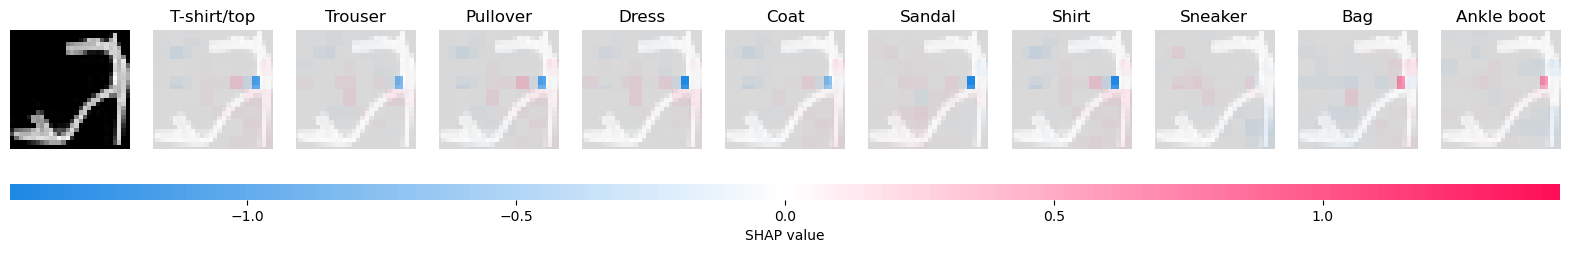

In [44]:
## this code is developed by Jose Maria Alonso-Moral
i=8
mapping = {0:"T-shirt/top",1:"Trouser",2:"Pullover",3:"Dress",4:"Coat",5:"Sandal",6:"Shirt",7:"Sneaker",8:"Bag",9:"Ankle boot"}
shap_values = explainerKeras(test_images[i:i+1])
#print(shap_values)
shap.image_plot(shap_values)

### **Illustrative Example: Explaining classification of hand-written numbers**

Finally, let us see another example of how to explain image classification (decimal numbers). For further details, see [PyTorch MNIST tutorial](https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/PyTorch%20Deep%20Explainer%20MNIST%20example.html).

In [45]:
## this code is developed by Jose Maria Alonso-Moral
batch_size = 128
num_epochs = 2
device = torch.device('cpu')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306682
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.221073
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.583083
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.058025
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.800882

Test set: Average loss: 0.0050, Accuracy: 8916/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.779608
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.641619
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.741378
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.426927
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.429471

Test set: Average loss: 0.0025, Accuracy: 9342/10000 (93%)



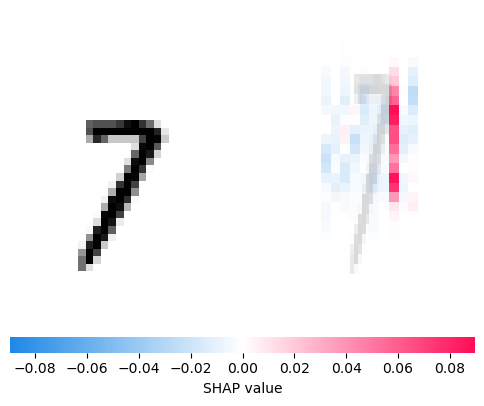

In [46]:
## this code is developed by Jose Maria Alonso-Moral
# since shuffle=True, this is a random sample of test data
batch = next(iter(test_loader))
images, _ = batch

background = images[:100]
test_images = images[100:101]

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)